In [8]:
import pyqlab
from pyqlab.dataset import Dataset
from pyqlab.sigprocess import *
import scipy
from scipy.ndimage import gaussian_filter1d

In [9]:
import torch
import numpy as np

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget
import plotly
import dash
from tqdm.auto import tqdm
import seaborn as sns
sns.set_theme()

In [11]:
rawdata_08_bias200mV=Dataset('/home/qqing/data/08_tunneling_bias_200mV.h5')

In [12]:
data=rawdata_08_bias200mV

bias_datalist=[]
bias_data=[]
current_datalist=[]
current_data=[]

dlist=data['/Tunneling bias '].dataset_list
for i, id in tqdm(enumerate(dlist), total=len(dlist), desc="Reading bias data   :"):
    bias_datalist.append(data.get_path(id))
    bias_data.append(data[id].data)
bias=np.concatenate(bias_data)

dlist=data['/Tunneling current '].dataset_list
for i, id in tqdm(enumerate(dlist), total=len(dlist), desc="Reading current data    :"):
    current_datalist.append(data.get_path(id))
    current_data.append(data[id].data)
current=np.concatenate(current_data)

conductance = (-current*1e9)/bias

Reading bias data   ::   0%|          | 0/21 [00:00<?, ?it/s]

Reading current data    ::   0%|          | 0/21 [00:00<?, ?it/s]

In [20]:
cut_off=1500.0 #Hz
fs = 50000.0 #Hz
gaussian_sigma=100

xscale_forward = lambda a: a*(1/fs)
xscale_inverse = lambda a: a*fs

conductance_smooth=lowpass_butterfly(conductance, cut_off, fs)
conductance_gaussianfiltered=gaussian_filter1d(conductance_smooth, gaussian_sigma)

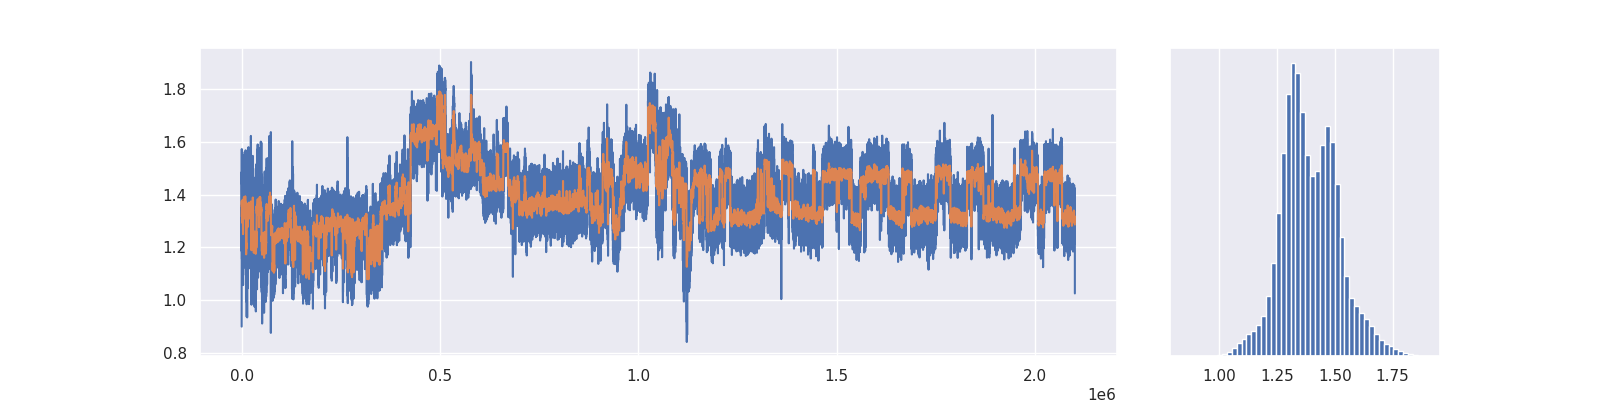

In [21]:

fig_cond=plt.figure()
fig_cond.set_figheight(4)
fig_cond.set_figwidth(16)

plt.subplot(1, 4, (1, 3))
plt.plot(conductance_smooth)
plt.plot(conductance_gaussianfiltered)
plt.xscale('function', functions=(xscale_forward, xscale_inverse))

plt.subplot(1, 4, 4)
plt.hist(conductance_smooth, bins=50)
fig_cond.axes[1].get_yaxis().set_visible(False)
plt.show()

In [22]:
plt.close(fig_cond)

In [23]:
step_vector=np.concatenate((np.ones(100, dtype=float), -1*np.ones(100, dtype=float)))

In [28]:
conv_cond = np.convolve(conductance_gaussianfiltered, step_vector)
delta_len=conv_cond.size-conductance_smooth.size

threshold=4
idx= np.abs(conv_cond)>threshold
t=np.arange(0, conv_cond.size)
conv_cond_sel=conv_cond[idx]
t_sel=t[idx]
t_sel-=delta_len



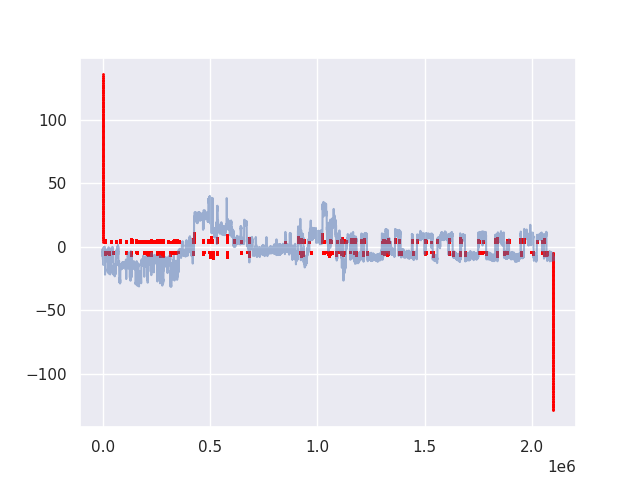

In [29]:
fig_convolve=plt.figure()
plt.plot((conductance_gaussianfiltered-np.average(conductance_gaussianfiltered))*100, alpha=0.5)
plt.scatter(t_sel, conv_cond_sel, s=1, c='red')
plt.show()